In [1]:
from gptopt.optim.pdhg import *
from utils_pdhg import *
from gptopt.optim.least_squares import * 

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 200

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=n=50$

In [4]:
m = n = 50
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 0.0005

mu_reg = 0
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=4.9820e-01


In [5]:
Z_star_1, Z_star_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [6]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [7]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2)).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [8]:
print(
    f"{f_star=:.4e}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)

f_star=-2.5147e-04, -0.0002514700754545629, 
cvxpy constraint violation: 6.295740604192468e-07


In [9]:
residuals_cold_start = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta=beta, mu_reg=mu_reg, f_star=f_star, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

Y0, _ = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=100) 
(Z1_0, Z2_0), _ = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                              tol=1e-10, maxit=100, diag_scaling=True)
        
residuals_warm_start = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, Z1_0=Z1_0, Z2_0=Z2_0, Y0=Y0,
                                        beta=beta, mu_reg=mu_reg, f_star=f_star, stopping=False, max_iter=max_iter, eps_abs=1e-5)

lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
Method                 Obj          Viol
----------------------------------------
PDHG          -1.825981e-04  5.230976e-02
PDHG DS       -2.086206e-04  4.645640e-02
PDHG Acc      -1.825981e-04  5.230976e-02
HPDHG DS      -1.775125e-04  2.986128e-02
reHPDHG DS    -2.098241e-04  1.501588e-02
HPDHG         -1.775125e-04  2.986128e-02
reHPDHG       -1.840922e-04  1.768353e-02
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
Method                 Obj          Viol
----------------------------------------
PDHG          -3.270540e-06  7.006752e-02
PDHG DS       -9.075984e-05  6.975366e-02
PDHG Acc      -3.270540e-06  7.006752e-02
HPDHG DS  

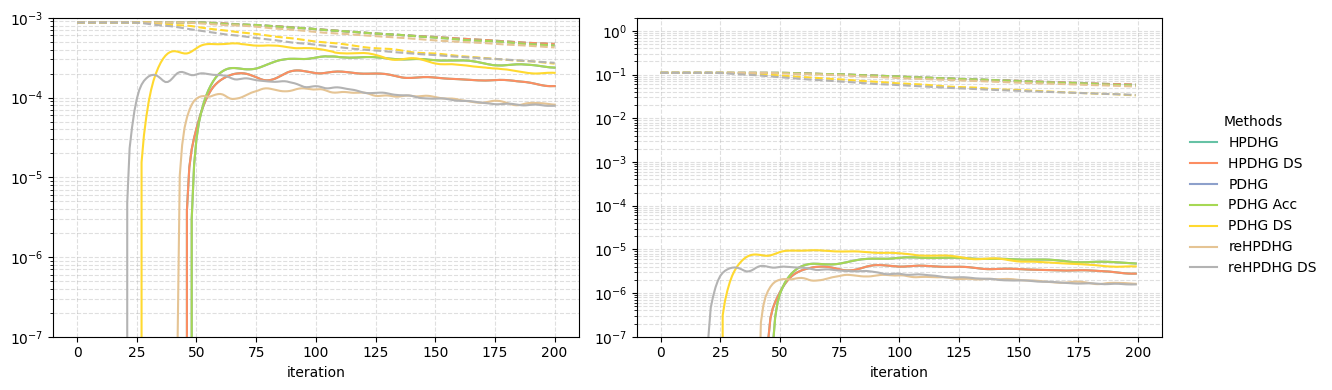

In [10]:
plot_residuals_compare(residuals_cold_start, dpi=100, dual_scale=True,
                       abs_ylim=(1e-7, 1e-3), rel_ylim=(1e-7, 2)
                       )

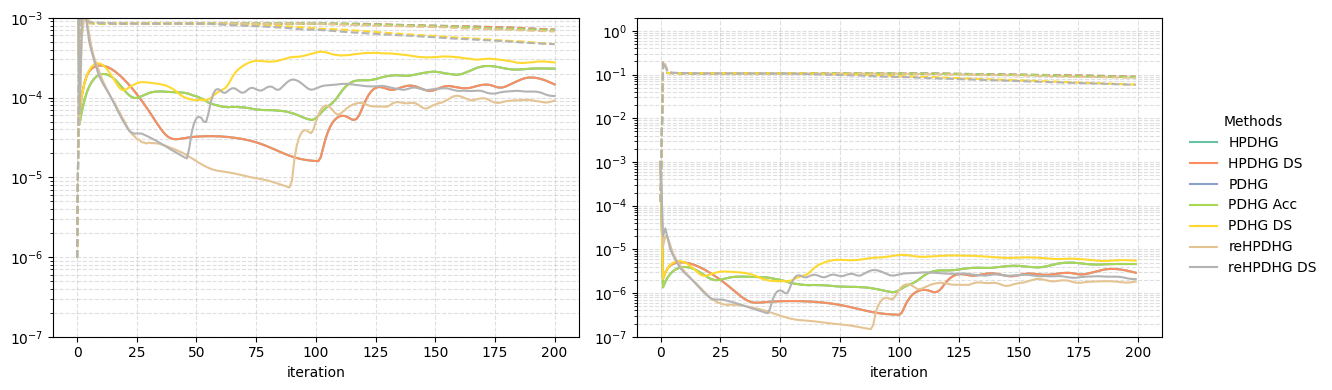

In [11]:
plot_residuals_compare(residuals_warm_start, dpi=100, dual_scale=True,
                       abs_ylim=(1e-7, 1e-3), rel_ylim=(1e-7, 2)
                       )

#  $m=n=1000$

In [12]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=3.7619e+00


In [13]:
residuals_cold_start, residuals_warm_start = {}, {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}") 
    residuals_cold_start[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta=beta, mu_reg=mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

    Y0, _ = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=100) 
    (Z1_0, Z2_0), _ = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                                tol=1e-10, maxit=100, diag_scaling=True)
            
    residuals_warm_start[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, Z1_0=Z1_0, Z2_0=Z2_0, Y0=Y0,
                                            beta=beta, mu_reg=mu_reg, f_star=None, stopping=False, max_iter=max_iter, eps_abs=1e-5)

beta=0.001, lamb_max=3.7619e+00
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
Method                 Obj          Viol
----------------------------------------
PDHG          -8.190031e-01  1.173229e+00
PDHG DS       -1.018616e+00  1.776846e+00
PDHG Acc      -8.190031e-01  1.173229e+00
HPDHG DS      -9.601523e-01  5.760449e-01
reHPDHG DS    -9.729699e-01  2.681929e-01
HPDHG         -9.601523e-01  5.760449e-01
reHPDHG       -9.210459e-01  2.754310e-01
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
Method                 Obj          Viol
----------------------------------------
PDHG          -4.844523e-01  1.151098e+00
PDHG DS       -7.716823e-01  1.844546e+00
PDHG Acc      -4.844523e-01  1.151

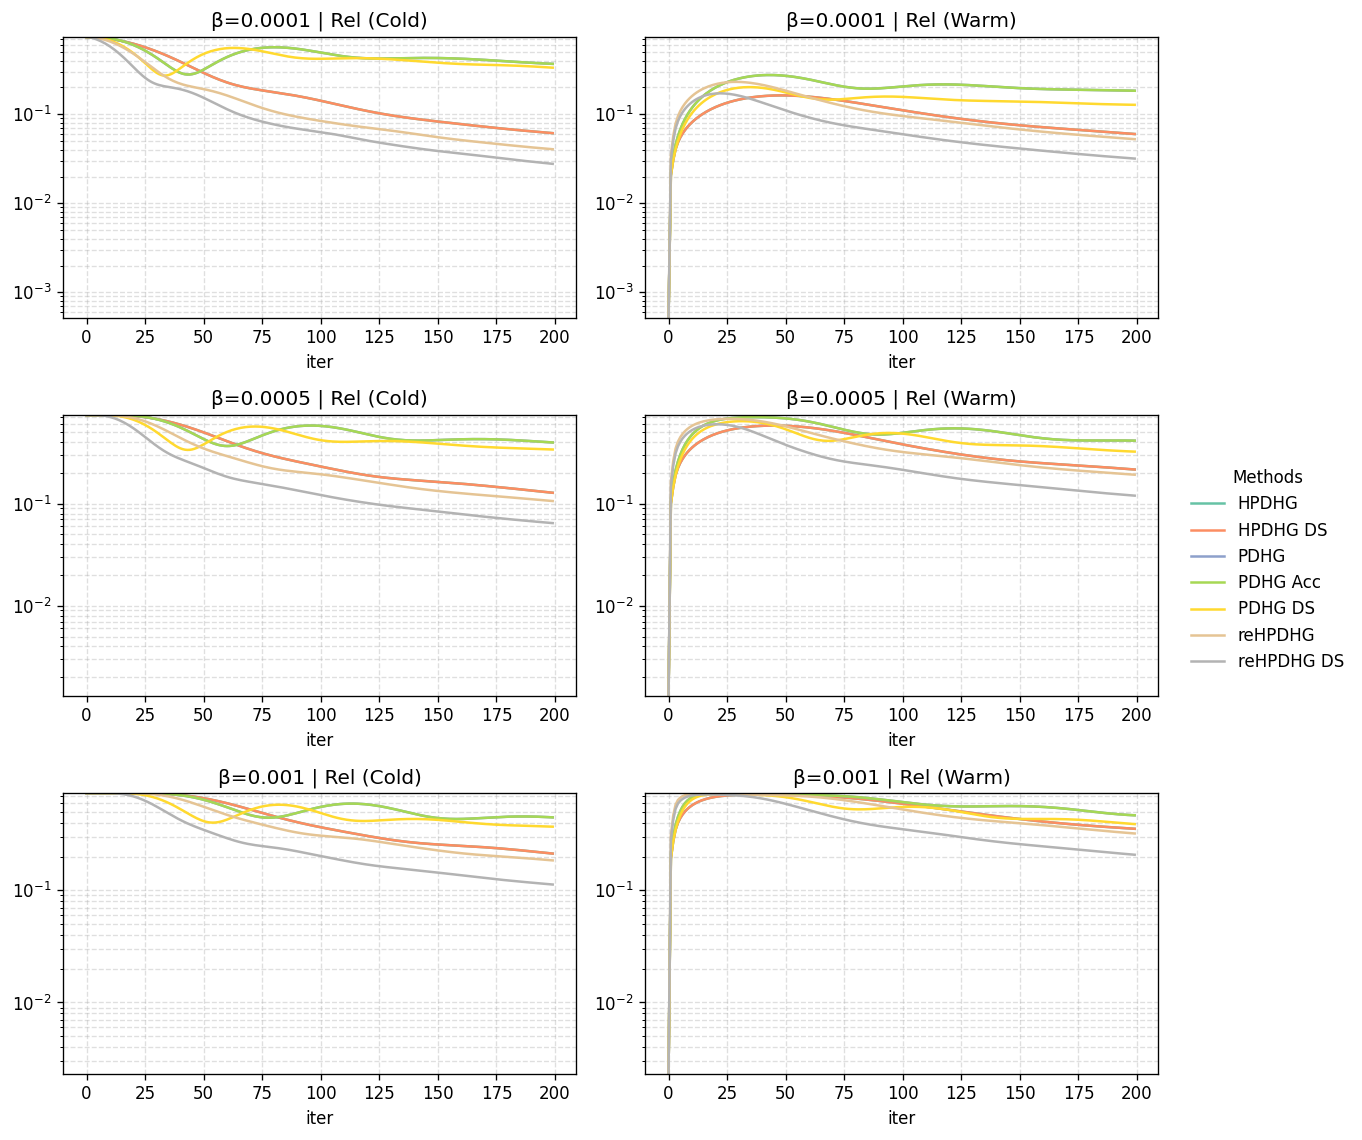

In [14]:
_ = plot_residuals_cold_warm_grid_by_param(
    residuals_cold_start,
    residuals_warm_start,
    param_name="beta", 
    dpi=120, 
)

#  $m=n=1000$

In [15]:
m = n = 1000
std2 = 0.1
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)


nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

mu_reg=0.0000e+00, lamb_max=9.9972e+00


In [16]:
residuals_cold_start, residuals_warm_start = {}, {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}") 
    residuals_cold_start[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta=beta, mu_reg=mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

    Y0, _ = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=100) 
    (Z1_0, Z2_0), _ = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                                tol=1e-10, maxit=100, diag_scaling=True)
            
    residuals_warm_start[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, Z1_0=Z1_0, Z2_0=Z2_0, Y0=Y0,
                                            beta=beta, mu_reg=mu_reg, f_star=None, stopping=False, max_iter=max_iter, eps_abs=1e-5)

beta=0.001, lamb_max=9.9972e+00
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
Method                 Obj          Viol
----------------------------------------
PDHG          -3.108827e-02  2.121686e-01
PDHG DS       -5.205247e-02  2.078953e-01
PDHG Acc      -3.108827e-02  2.121686e-01
HPDHG DS      -2.835664e-02  1.631114e-01
reHPDHG DS    -5.207699e-02  1.028764e-01
HPDHG         -2.835664e-02  1.631114e-01
reHPDHG       -3.198604e-02  9.536806e-02
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
Method                 Obj          Viol
----------------------------------------
PDHG          7.129629e-02  4.386709e-02
PDHG DS       4.883561e-02  2.995492e-01
PDHG Acc      7.129629e-02  4.386709e-02
HPDHG DS 

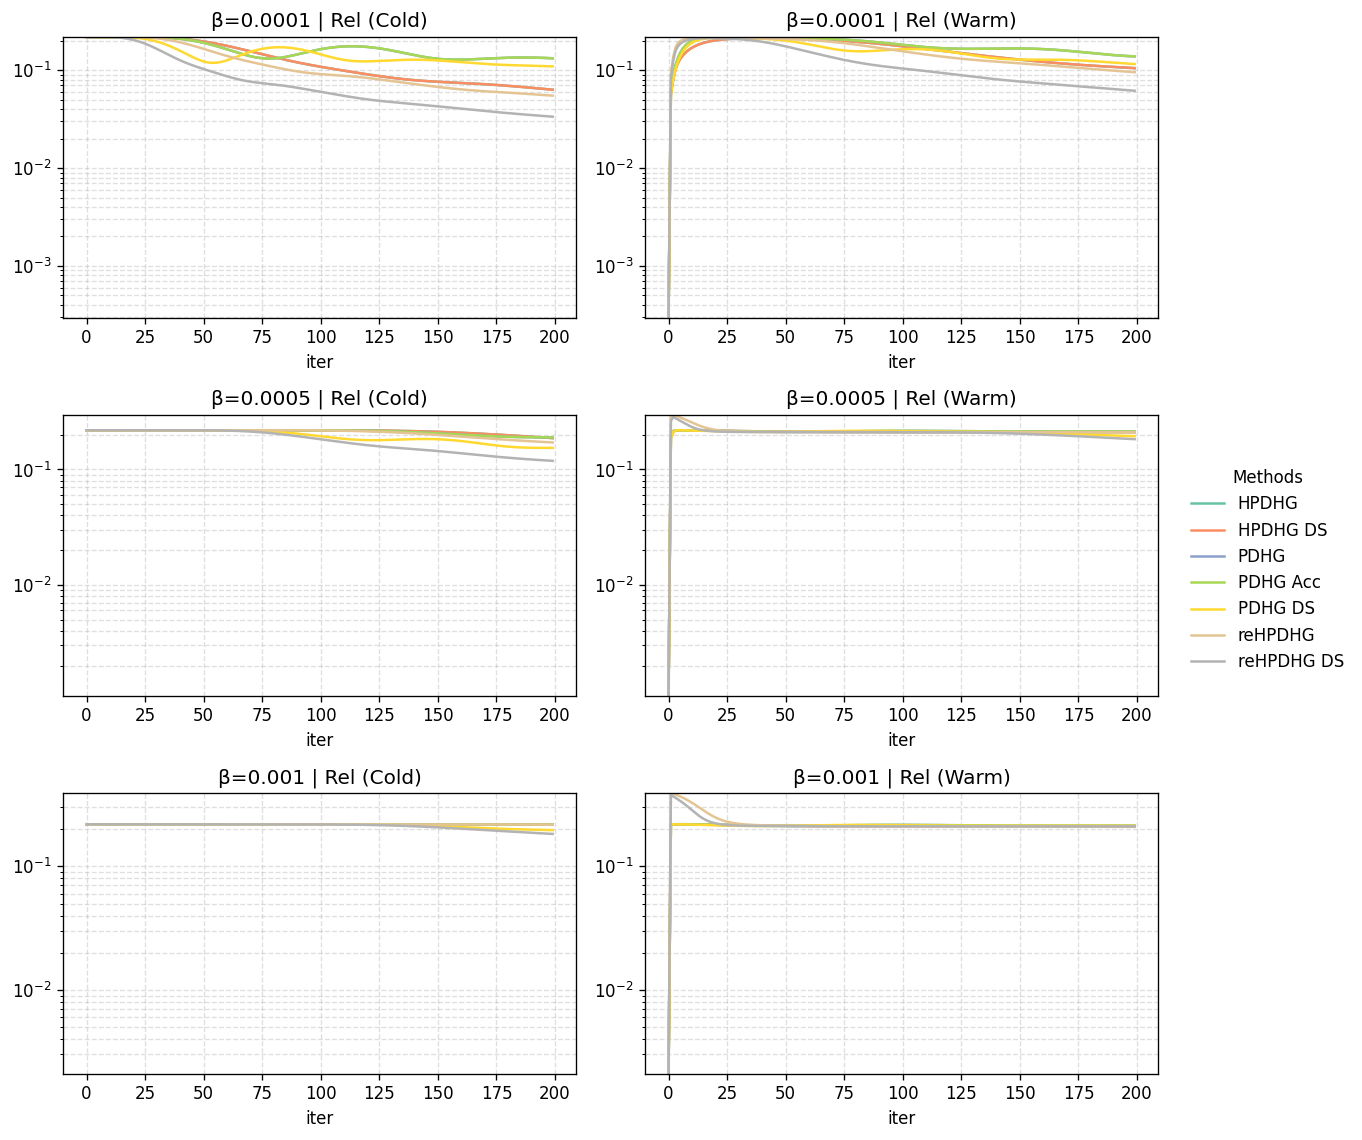

In [17]:
_ = plot_residuals_cold_warm_grid_by_param(
    residuals_cold_start,
    residuals_warm_start,
    param_name="beta", 
    dpi=120, 
)